In [ ]:
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import os

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
sns.set(style="whitegrid", color_codes=True)

In [ ]:
import imblearn

## Load datasets 

In [6]:
print("Loading the data ... ")
train_data        = pd.read_csv(os.path.join(os.getcwd(), "ml_case_data/ml_case_training_data.csv"),  
                                index_col='id', na_values='')
train_data_hist   = pd.read_csv(os.path.join(os.getcwd(), "ml_case_data/ml_case_training_hist_data.csv"), 
                                index_col='id', na_values='')
train_data_output = pd.read_csv(os.path.join(os.getcwd(), "ml_case_data/ml_case_training_output.csv"),      
                                index_col='id', na_values='')
test_data         = pd.read_csv(os.path.join(os.getcwd(), "ml_case_data/ml_case_test_data.csv"),
                                index_col='id', na_values='')
test_data_hist    = pd.read_csv(os.path.join(os.getcwd(), "ml_case_data/ml_case_test_hist_data.csv"), 
                                index_col='id', na_values='')
test_data_output  = pd.read_csv(os.path.join(os.getcwd(), "ml_case_data/ml_case_test_output_template.csv"),
                                index_col='id', na_values='')

print("train_data shape:        " + str(train_data.shape))
print("train_data_hist shape:   " + str(train_data_hist.shape))
print("train_data_output shape: " + str(train_data_output.shape))
print("test_data shape:         " + str(test_data.shape))
print("test_data_hist shape:    " + str(test_data_hist.shape))
print("test_data_output shape:  " + str(test_data_output.shape))

Loading the data ... 
train_data shape:        (16096, 31)
train_data_hist shape:   (193002, 7)
train_data_output shape: (16096, 1)
test_data shape:         (4024, 31)
test_data_hist shape:    (48236, 7)
test_data_output shape:  (4024, 3)


## Clean datasets:  

In [7]:
# merge training data with training output 
train_data = pd.concat([train_data,train_data_output], axis=1)

In [8]:
train_data = train_data.drop(columns = ["campaign_disc_ele"]) # whole column is empty
test_data  = test_data.drop(columns = ["campaign_disc_ele"])  # whole column is empty

In [9]:
has_gas = {'f': 0,'t': 1} # convert has_gas into 0/1
train_data.has_gas = [has_gas[item] for item in train_data.has_gas]
test_data.has_gas = [has_gas[item] for item in test_data.has_gas]

In [10]:
numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64'] 
numeric_train_data = train_data.select_dtypes(include=numerics) # only select numerical data
numeric_test_data  =  test_data.select_dtypes(include=numerics) # only select numerical data

In [11]:
print("nan values in train set: \n")
train_data_col_nan = numeric_train_data.columns[numeric_train_data.isna().any()].tolist()
for col in train_data_col_nan:
    summed_nans = train_data[col].isnull().sum()
    print(str(col) + " has: " + str(summed_nans) + " NaN values")

nan values in train set: 

forecast_base_bill_ele has: 12588 NaN values
forecast_base_bill_year has: 12588 NaN values
forecast_bill_12m has: 12588 NaN values
forecast_cons has: 12588 NaN values
forecast_discount_energy has: 126 NaN values
forecast_price_energy_p1 has: 126 NaN values
forecast_price_energy_p2 has: 126 NaN values
forecast_price_pow_p1 has: 126 NaN values
margin_gross_pow_ele has: 13 NaN values
margin_net_pow_ele has: 13 NaN values
net_margin has: 15 NaN values
pow_max has: 3 NaN values


In [12]:
print("nan values in test set: \n")
test_data_col_nan = numeric_test_data.columns[numeric_test_data.isna().any()].tolist()
for col in test_data_col_nan:
    summed_nans = test_data[col].isnull().sum()
    print(str(col) + " has: " + str(summed_nans) + " NaN values")

nan values in test set: 

forecast_base_bill_ele has: 3147 NaN values
forecast_base_bill_year has: 3147 NaN values
forecast_bill_12m has: 3147 NaN values
forecast_cons has: 3147 NaN values
forecast_discount_energy has: 24 NaN values
forecast_price_energy_p1 has: 24 NaN values
forecast_price_energy_p2 has: 24 NaN values
forecast_price_pow_p1 has: 24 NaN values
margin_gross_pow_ele has: 2 NaN values
margin_net_pow_ele has: 2 NaN values
net_margin has: 3 NaN values
pow_max has: 1 NaN values


In [13]:
most_nan_columns = ["forecast_base_bill_ele", "forecast_base_bill_year",
                    "forecast_bill_12m", "forecast_cons"] # both for train and test set the columns with most NaN values

In [14]:
# drop the nan columns: 
numeric_train_data = numeric_train_data.drop(columns = most_nan_columns)
numeric_test_data  = numeric_test_data.drop(columns = most_nan_columns)

In [15]:
still_nan_columns = []
train_data_col_nan = numeric_train_data.columns[numeric_train_data.isna().any()].tolist()
for col in train_data_col_nan:
    still_nan_columns.append(col)

In [16]:
still_nan_columns

['forecast_discount_energy',
 'forecast_price_energy_p1',
 'forecast_price_energy_p2',
 'forecast_price_pow_p1',
 'margin_gross_pow_ele',
 'margin_net_pow_ele',
 'net_margin',
 'pow_max']

In [17]:
# fill the rest of the NaN values with the median from churned and staying customers!
#for nan_col in still_nan_columns: 
#    staying_median = numeric_train_data.groupby(by="churn")[nan_col].median()[0]
#    churned_median = numeric_train_data.groupby(by="churn")[nan_col].median()[1]
#    print(nan_col)
#    print(staying_median)
#    print(churned_median)
#    numeric_train_data[numeric_train_data["churn"] == 0][nan_col] = numeric_train_data[numeric_train_data["churn"] == 0][nan_col].fillna(value=staying_median)
#    numeric_train_data[numeric_train_data["churn"] == 1][nan_col] = numeric_train_data[numeric_train_data["churn"] == 1][nan_col].fillna(value=churned_median)
#    numeric_test_data[nan_col] = numeric_test_data[nan_col].fillna(value=0.5*(staying_median+churned_median))

In [18]:
numeric_train_data = numeric_train_data.fillna(value=0)
numeric_test_data = numeric_test_data.fillna(value=0)

There are some things I am not really clear about: 
1. what is the difference between power and electricity + gas here and is electricity + gas = energy 
2. should I multiply the electricity consumption (in ml_case_training_data.csv) of the past 12 months with the average of the energy price (in ml_case_training_hist_data) for the 12 months? 
3. What is with gas consumption? is this in the energy price? I guess it would not be reasonable to assume that electricity and gas prices are given with the same variable?
4. What is the electricity bill baseline for the next month? 
5. What discount are they offered? Is it the discount when/if they changed their product? 
6. What is current paid consumption? Is it for 01/2016 for energy and power?
7. I guess total net margin is what the company gained from the cust in the past 12 months? 
8. What is subscribed power? should I multiply this with the price of power in the historical data? 

## Visualize the correlation between the numeric data 

In [19]:
data_correlation = numeric_train_data.corr(method='spearman')
print("correlation: ")
data_correlation.style.format("{:.2}").background_gradient(cmap=plt.cm.Greens, axis=1)

correlation: 


,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,churn
cons_12m,1.0,0.17,0.73,0.71,0.46,-0.029,0.32,-0.33,0.32,-0.33,0.15,0.45,-0.19,-0.18,0.13,0.67,0.0073,0.39,-0.013
cons_gas_12m,0.17,1.0,0.15,0.14,0.089,0.0075,0.054,-0.038,0.064,-0.079,0.96,0.092,-0.038,-0.038,0.86,0.12,0.0029,0.074,-0.031
cons_last_month,0.73,0.15,1.0,0.48,0.77,-0.024,0.37,-0.32,0.37,-0.32,0.13,0.76,-0.1,-0.097,0.11,0.46,0.025,0.38,-0.026
forecast_cons_12m,0.71,0.14,0.48,1.0,0.55,0.038,0.31,-0.3,0.28,-0.3,0.13,0.55,-0.26,-0.25,0.12,0.93,-0.039,0.4,-0.00019
forecast_cons_year,0.46,0.089,0.77,0.55,1.0,0.0012,0.45,-0.41,0.43,-0.38,0.081,0.99,-0.12,-0.11,0.067,0.54,0.011,0.45,-0.0039
forecast_discount_energy,-0.029,0.0075,-0.024,0.038,0.0012,1.0,-0.013,0.25,0.08,0.13,0.008,0.019,0.22,0.21,0.14,-0.027,-0.084,-0.0073,0.012
forecast_meter_rent_12m,0.32,0.054,0.37,0.31,0.45,-0.013,1.0,-0.62,0.68,-0.51,0.046,0.43,-0.013,-0.0095,0.028,0.33,0.039,0.65,0.032
forecast_price_energy_p1,-0.33,-0.038,-0.32,-0.3,-0.41,0.25,-0.62,1.0,-0.47,0.58,-0.031,-0.36,0.18,0.17,0.017,-0.35,-0.078,-0.65,-0.035
forecast_price_energy_p2,0.32,0.064,0.37,0.28,0.43,0.08,0.68,-0.47,1.0,-0.66,0.061,0.4,0.12,0.12,0.062,0.33,0.00096,0.68,0.027
forecast_price_pow_p1,-0.33,-0.079,-0.32,-0.3,-0.38,0.13,-0.51,0.58,-0.66,1.0,-0.075,-0.34,-0.15,-0.16,-0.041,-0.37,0.034,-0.63,-0.04


In [20]:
data_correlation[(abs(data_correlation) > 0.8) & ( data_correlation != 1.0)].dropna(how="all", axis=(0,1))

,cons_gas_12m,forecast_cons_12m,forecast_cons_year,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin
cons_gas_12m,NaN,NaN,NaN,0.959448,NaN,NaN,NaN,0.863785,NaN
forecast_cons_12m,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.928239
forecast_cons_year,NaN,NaN,NaN,NaN,0.987641,NaN,NaN,NaN,NaN
has_gas,0.959448,NaN,NaN,NaN,NaN,NaN,NaN,0.898026,NaN
imp_cons,NaN,NaN,0.987641,NaN,NaN,NaN,NaN,NaN,NaN
margin_gross_pow_ele,NaN,NaN,NaN,NaN,NaN,NaN,0.991004,NaN,NaN
margin_net_pow_ele,NaN,NaN,NaN,NaN,NaN,0.991004,NaN,NaN,NaN
nb_prod_act,0.863785,NaN,NaN,0.898026,NaN,NaN,NaN,NaN,NaN
net_margin,NaN,0.928239,NaN,NaN,NaN,NaN,NaN,NaN,NaN


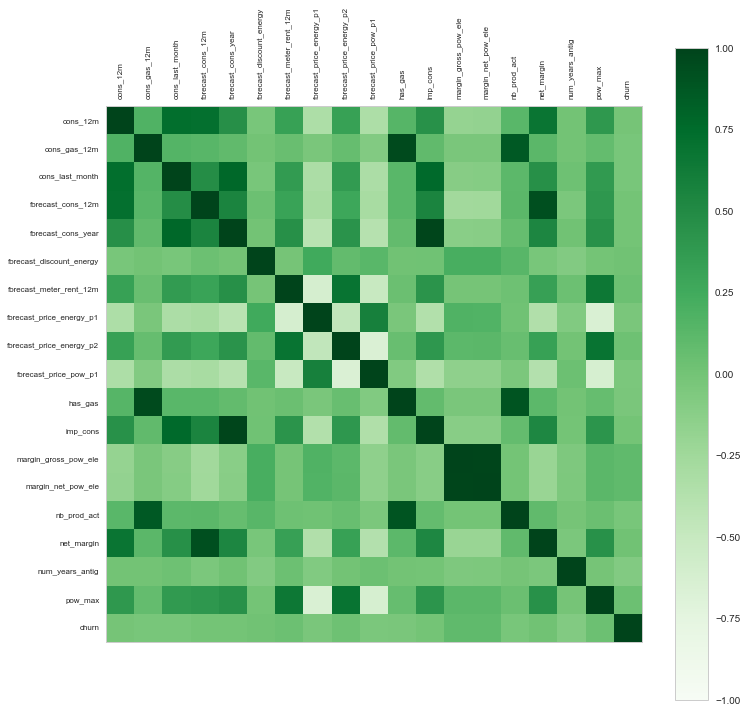

In [21]:
indices = data_correlation.index
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111)
cax = ax.matshow(data_correlation, vmin=-1, vmax=1, cmap=plt.cm.Greens)
fig.colorbar(cax)
ticks = np.arange(0,len(indices),1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
plt.xticks(rotation=90)
ax.set_xticklabels(indices, fontsize=8)
ax.set_yticklabels(indices, fontsize=8)
plt.grid()
plt.savefig("correlation_matrix.pdf")

We could remove highly correlated attributes, because they don't give us new information and bias certain ml models

In [22]:
colinear_columns = ["forecast_cons_year","forecast_cons_12m","has_gas","margin_gross_pow_ele"]

## Visualize important parameters for the churn classes 

Text(0.5,1,'Number of customers that stayed and churned')

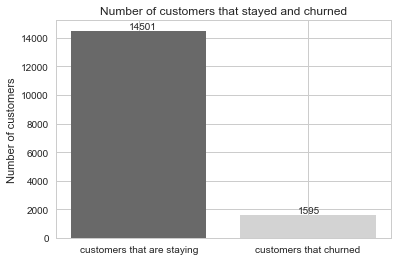

In [41]:
# imbalanced dataset! - factor of ~10
n_churned = np.sum(train_data_output["churn"] == 1) # or just sum over column, bc its binary
n_staying = np.sum(train_data_output["churn"] == 0)

fig, ax = plt.subplots()
staying, churned = plt.bar((0,1), (n_staying, n_churned))
staying.set_facecolor('dimgray')
churned.set_facecolor('lightgray')
ax.set_xticks((0,1))
for p in (ax.patches):
    ax.annotate(str(p.get_height()), (p.get_x()+0.34, p.get_height() +100), fontsize=10)
ax.set_xticklabels(['customers that are staying', 'customers that churned'])
ax.set_ylabel('Number of customers')
ax.set_title('Number of customers that stayed and churned')

In [2]:
median_by_churn = numeric_train_data.groupby(by="churn").median() # look where they differ
most_rel_diff_median = (median_by_churn.diff().iloc[1])/(median_by_churn.max()+1e-7) # get the once that differ relatively the most
most_rel_diff_median = most_rel_diff_median[abs(most_rel_diff_median) > 0.04].sort_values(ascending=False)

NameError: name 'numeric_train_data' is not defined

In [25]:
rel_max = median_by_churn[most_rel_diff_median.index.values]/median_by_churn[most_rel_diff_median.index.values].max().max()

In [58]:
%matplotlib inline

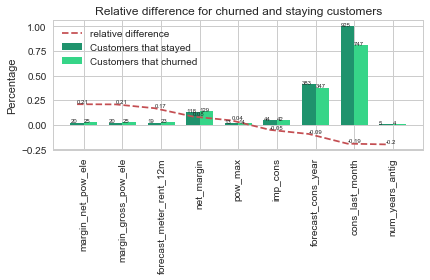

In [59]:
N = rel_max.shape[1]
stayingMedian = rel_max.iloc[0].values
churnMedian = rel_max.iloc[1].values
ind = np.arange(N)    

fig, ax = plt.subplots()
index = np.arange(N)
bar_width = 0.35

opacity = 1

ax.bar(index, stayingMedian, bar_width, alpha=opacity,
                color='#1F936D', label='Customers that stayed')


ax.bar(index + bar_width, churnMedian, bar_width, alpha=opacity,
                color='#36D588', label='Customers that churned')

ax.plot((most_rel_diff_median.values), color="r", linestyle="--", label = "relative difference")



# annotate line chart
for i,j in enumerate((most_rel_diff_median.values)):
    ax.annotate(str(np.round(j,2)),xy=(i,j+0.01), fontsize=6)
    
# annotate bar chart
len_median_by_churn = len(median_by_churn[most_rel_diff_median.index.values].iloc[0])
for i,p in enumerate(ax.patches):
    if i < len_median_by_churn:
        c_bar_value = int(median_by_churn[most_rel_diff_median.index.values].iloc[0][i])
    else: 
        c_bar_value = int(median_by_churn[most_rel_diff_median.index.values].iloc[1][i-len_median_by_churn])
    ax.annotate(str(c_bar_value), (p.get_x(), p.get_height() * 1.005), fontsize=6)


ax.set_ylabel('Percentage')
ax.set_title('Relative difference for churned and staying customers')
ax.set_xticks(index + bar_width / 2)
plt.xticks(rotation=90)

ax.set_xticklabels(rel_max.columns)
ax.legend()

fig.tight_layout()
plt.show()

In [60]:
churning_sales_channels = {}
for channel in np.unique(train_data["channel_sales"].dropna().values):
    c_sum = np.sum(train_data[train_data["channel_sales"] == channel]["churn"])
    print(channel + " has " + str(c_sum) +" churning customers")
    if c_sum > 0: 
        churning_sales_channels[channel] = c_sum

epumfxlbckeskwekxbiuasklxalciiuu has 0 churning customers
ewpakwlliwisiwduibdlfmalxowmwpci has 82 churning customers
fixdbufsefwooaasfcxdxadsiekoceaa has 0 churning customers
foosdfpfkusacimwkcsosbicdxkicaua has 922 churning customers
lmkebamcaaclubfxadlmueccxoimlema has 116 churning customers
sddiedcslfslkckwlfkdpoeeailfpeds has 0 churning customers
usilxuppasemubllopkaafesmlibmsdf has 150 churning customers


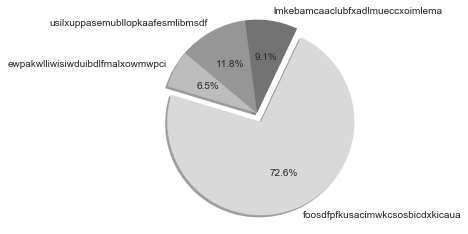

In [61]:
# Data to plot
labels = churning_sales_channels.keys()
sizes = churning_sales_channels.values()
explode = (0, 0.1, 0, 0)  # explode 1st slice
colors = ["#bdbdbd","#d9d9d9","#737373","#969696"]
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
#plt.savefig("churning_customers_by_sales_channel.pdf")
plt.show()

Text(0.5,1,'Number of customers that stayed and churned')

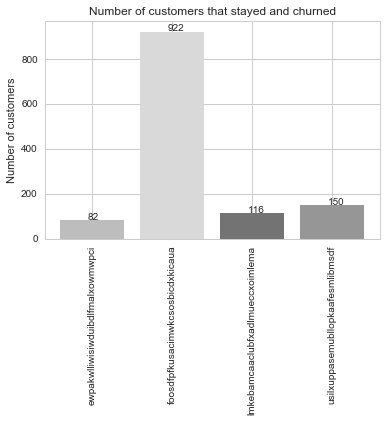

In [62]:
fig, ax = plt.subplots()

channel_1 = churning_sales_channels[list(churning_sales_channels.keys())[0]]
channel_2 = churning_sales_channels[list(churning_sales_channels.keys())[1]]
channel_3 = churning_sales_channels[list(churning_sales_channels.keys())[2]]
channel_4 = churning_sales_channels[list(churning_sales_channels.keys())[3]]

channel_1, channel_2, channel_3, channel_4 = plt.bar((0,1,2,3), (channel_1, channel_2, channel_3, channel_4))

colors = ["#bdbdbd","#d9d9d9","#737373","#969696"]

channel_1.set_facecolor('#bdbdbd')
channel_2.set_facecolor('#d9d9d9')
channel_3.set_facecolor('#737373')
channel_4.set_facecolor('#969696')

ax.set_xticks((0,1,2,3))
for p in (ax.patches):
    ax.annotate(str(p.get_height()), (p.get_x()+0.34, p.get_height()*1.005), fontsize=10)
ax.set_xticklabels( churning_sales_channels.keys())
plt.xticks(rotation=90)
ax.set_ylabel('Number of customers')
ax.set_title('Number of customers that stayed and churned')

In [63]:
train_all_sales_channel_churning_cust = train_data.loc[train_data['channel_sales'].isin(churning_sales_channels)]

In [64]:
train_all_sales_channel_churning_cust.groupby(by=["channel_sales", "churn"]).median()

cons_12m  cons_gas_12m  \
channel_sales                    churn                           
ewpakwlliwisiwduibdlfmalxowmwpci 0       11124.5           0.0   
                                 1       13348.5           0.0   
foosdfpfkusacimwkcsosbicdxkicaua 0       16245.0           0.0   
                                 1       17325.5           0.0   
lmkebamcaaclubfxadlmueccxoimlema 0      116614.0           0.0   
                                 1       43651.0           0.0   
usilxuppasemubllopkaafesmlibmsdf 0        7980.5           0.0   
                                 1        8211.0           0.0   

                                        cons_last_month  \
channel_sales                    churn                    
ewpakwlliwisiwduibdlfmalxowmwpci 0                354.0   
                                 1                260.5   
foosdfpfkusacimwkcsosbicdxkicaua 0                964.0   
                                 1                782.5   
lmkebamcaaclubfxadlmueccxoimlema 0               9261.0   
                                 1               2840.5   
usilxuppasemubllopkaafesmlibmsdf 0                187.5   
                                 1                274.5   

                                        forecast_base_bill_ele  \
channel_sales                    churn                           
ewpakwlliwisiwduibdlfmalxowmwpci 0                     138.250   
                                 1                     183.205   
foosdfpfkusacimwkcsosbicdxkicaua 0                     166.950   
                                 1                     194.610   
lmkebamcaaclubfxadlmueccxoimlema 0                     238.675   
                                 1                     236.510   
usilxuppasemubllopkaafesmlibmsdf 0                       0.000   
                                 1                     169.075   

                                        forecast_base_bill_year  \
channel_sales                    churn                            
ewpakwlliwisiwduibdlfmalxowmwpci 0                      138.250   
                                 1                      183.205   
foosdfpfkusacimwkcsosbicdxkicaua 0                      166.950   
                                 1                      194.610   
lmkebamcaaclubfxadlmueccxoimlema 0                      238.675   
                                 1                      236.510   
usilxuppasemubllopkaafesmlibmsdf 0                        0.000   
                                 1                      169.075   

                                        forecast_bill_12m  forecast_cons  \
channel_sales                    churn                                     
ewpakwlliwisiwduibdlfmalxowmwpci 0               1891.020         58.300   
                                 1               2755.170         69.485   
foosdfpfkusacimwkcsosbicdxkicaua 0               2240.005         46.550   
                                 1               2470.320         57.075   
lmkebamcaaclubfxadlmueccxoimlema 0               3449.920         81.320   
                                 1               2813.900         44.600   
usilxuppasemubllopkaafesmlibmsdf 0               1634.675          0.000   
                                 1               1839.265         49.385   

                                        forecast_cons_12m  forecast_cons_year  \
channel_sales                    churn                                          
ewpakwlliwisiwduibdlfmalxowmwpci 0               1070.020                97.0   
                                 1               1088.905               166.0   
foosdfpfkusacimwkcsosbicdxkicaua 0               1196.220               449.0   
                                 1               1282.670               443.5   
lmkebamcaaclubfxadlmueccxoimlema 0               1877.290               705.0   
                                 1               1932.160               433.0   
usilxuppasemubllopkaafesmlibmsdf 0             

In [68]:
train_median_gas_churn = train_data.drop(columns="cons_gas_12m").groupby(by=["has_gas", "churn"]).median()

In [69]:
difference_of_has_gas_churn = train_median_gas_churn.iloc[3] - train_median_gas_churn.iloc[2]

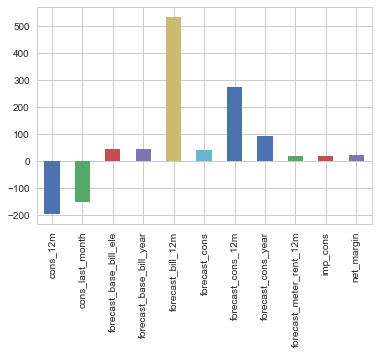

In [70]:
difference_of_has_gas_churn[abs(difference_of_has_gas_churn) > 10].plot.bar()

### Prepare train and test set via downsampling

In [71]:
train_staying = numeric_train_data[numeric_train_data["churn"] == 0].drop(columns=["churn"])
train_churned = numeric_train_data[numeric_train_data["churn"] == 1].drop(columns=["churn"])

In [72]:
# balance the dataset: 
indices = np.arange(train_staying.shape[0])
random_indices = np.random.choice(indices, size = train_churned.shape[0])
train_staying = train_staying.iloc[random_indices] # choose random staying customers
X_train_downsampled = pd.concat((train_staying, train_churned))
y_train_downsampled = np.concatenate((np.zeros(train_staying.shape[0]), np.ones(train_churned.shape[0])))

In [73]:
X_train_downsampled, X_test_downsampled, y_train_downsampled, y_test_downsampled = train_test_split(X_train_downsampled, y_train_downsampled)

balanced churn set: 


Text(0.5,1,'Number of customers that stayed and churned')

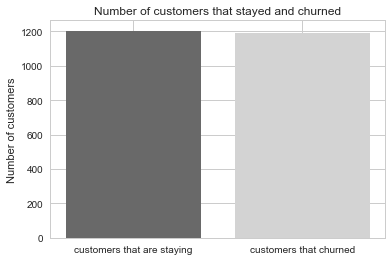

In [74]:
print("balanced churn set: ")
# imbalanced dataset! - factor of ~10
n_churned_balanced = np.sum(y_train_downsampled == 1) # or just sum over column, bc its binary
n_staying_balanced = np.sum(y_train_downsampled == 0)

fig, ax = plt.subplots()
staying, churned = plt.bar((0,1), (n_churned_balanced, n_staying_balanced))
staying.set_facecolor('dimgray')
churned.set_facecolor('lightgray')
ax.set_xticks((0,1))

ax.set_xticklabels(['customers that are staying', 'customers that churned'])
ax.set_ylabel('Number of customers')
ax.set_title('Number of customers that stayed and churned')

In [75]:
#X_train_downsampled.to_pickle("X_train_downsampled.pickle")
#X_test_downsampled.to_pickle("X_test_downsampled.pickle")
#y_train_downsampled.dump("y_train_downsampled.pickle")
#y_test_downsampled.dump("y_test_downsampled.pickle")
#print(X_train_downsampled.shape)
#print(y_train_downsampled.shape)
#print(X_test_downsampled.shape)
#print(y_test_downsampled.shape)

In [76]:
X_train_downsampled = pd.read_pickle("X_train_downsampled.pickle")
X_test_downsampled  = pd.read_pickle("X_test_downsampled.pickle")
y_train_downsampled = np.load("y_train_downsampled.pickle")
y_test_downsampled  = np.load("y_test_downsampled.pickle")

In [77]:
X_train_no_colinear_cols = X_train_downsampled.drop(columns=colinear_columns)
X_test_no_colinear_cols  = X_test_downsampled.drop(columns=colinear_columns)

In [78]:
def plot_confusion_matrix(y_true, y_pred, filename): 
    plt.figure()
    mat = confusion_matrix(y_true, y_pred)
    sns.heatmap(mat, square=True, annot=True, fmt='d', cmap="YlGnBu", cbar=True)
    plt.ylabel('true label'),
    plt.xlabel('predicted label')
    plt.savefig(filename+".pdf")
    plt.figure()
    mat_normalized = mat / mat.sum(axis=1)
    sns.heatmap(mat_normalized, fmt="f", square=True, annot=True, cmap="YlGnBu", cbar=True)
    plt.ylabel('true label'),
    plt.xlabel('predicted label')
    print("confusion matrix normalized: ")
    plt.savefig(filename+"_normalized.pdf")

### Prepare train and test set via upsampling 

#### 1. Synthetic Minority Oversampling Technique (SMOTE)  

In [138]:
from imblearn.over_sampling import SMOTE

In [139]:
train_staying = numeric_train_data[numeric_train_data["churn"] == 0].drop(columns=["churn"])
train_churned = numeric_train_data[numeric_train_data["churn"] == 1].drop(columns=["churn"])

In [140]:
train_staying = train_staying.drop(columns=["nb_prod_act","num_years_antig","has_gas"]) # drop discrete values
train_churned = train_churned.drop(columns=["nb_prod_act","num_years_antig","has_gas"]) # drop discrete values

In [141]:
X_unbalanced = np.concatenate((train_staying, train_churned))

In [142]:
y_unbalanced = np.concatenate((np.zeros(train_staying.shape[0]),np.ones(train_churned.shape[0])))

In [143]:
X_train_upsampled, X_test_upsampled, y_train_upsampled, y_test_upsampled = train_test_split(X_unbalanced, y_unbalanced)

In [144]:
n_staying_in_upsampled_train = np.sum(y_train_upsampled == 0)
n_churned_in_upsampled_train = np.sum(y_train_upsampled == 1)

In [145]:
X_train_upsampled, y_train_upsampled = SMOTE(random_state=42, ratio={0:n_staying_in_upsampled_train, 1:n_staying_in_upsampled_train}).fit_sample(X_train_upsampled, y_train_upsampled)

In [146]:
n_staying_in_upsampled_test = np.sum(y_test_upsampled == 0)

In [147]:
X_test_upsampled, y_test_upsampled = SMOTE(random_state=42, ratio={0:n_staying_in_upsampled_test, 1:n_staying_in_upsampled_test}).fit_sample(X_test_upsampled, y_test_upsampled)

### Decision tree on downsampled data

In [89]:
from sklearn import tree
import pydot

In [99]:
from sklearn.metrics import recall_score, precision_score

In [90]:
def get_best_dec_tree(X_train,y_train,X_test, y_test):
    best_acc = 0
    best_depth = 0
    for i in range(3,20):
        dec_tree = tree.DecisionTreeClassifier(max_depth = i, random_state=42)
        dec_tree = dec_tree.fit(X_train, y_train)
        y_pred = dec_tree.predict(X_test)
        acc_score = accuracy_score(y_test, y_pred)
        if acc_score > best_acc: 
            best_acc = acc_score
            best_depth = i
    dec_tree = tree.DecisionTreeClassifier(max_depth = best_depth, random_state=42)
    dec_tree.fit(X_train, y_train)
    y_pred = dec_tree.predict(X_test)
    print("the accuracy = " + str(accuracy_score(y_test, y_pred)))
    return dec_tree, y_pred

In [91]:
def plot_dec_tree(decision_tree, feature_names, filename):
    dot_data = tree.export_graphviz(decision_tree, out_file=None, 
                                feature_names=feature_names,
                                filled=True,
                                rounded=True) 
    graph = pydot.graph_from_dot_data(dot_data)
    graph[0].write_png(filename+".png")

In [92]:
dec_tree_classifier, y_pred = get_best_dec_tree(X_train=X_train_downsampled, y_train=y_train_downsampled,
                                       X_test=X_test_downsampled, y_test=y_test_downsampled)

the accuracy = 0.6052631578947368


In [93]:
accuracy_score(y_test_downsampled, y_pred)

0.6052631578947368

saving confusion matrix for decision tree...
confusion matrix normalized: 


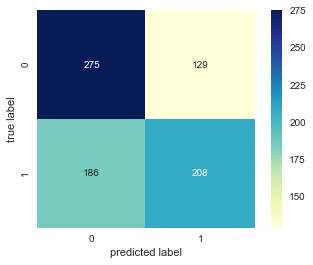

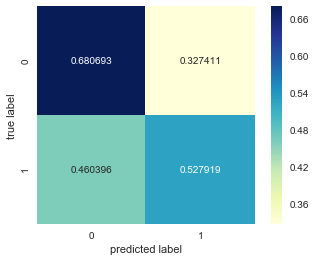

In [94]:
print("saving confusion matrix for decision tree...")
plot_confusion_matrix(y_test_downsampled, y_pred, "decision_tree_downsampled_conf_matrix")

In [95]:
plot_dec_tree(dec_tree_classifier, feature_names=X_train_downsampled.columns, filename="decision_tree_downsampled")

In [97]:
recall_score(y_test_downsampled, y_pred)

0.5279187817258884

In [100]:
precision_score(y_test_downsampled, y_pred)

0.6172106824925816

## Decision tree on upsampled data: 

In [109]:
dec_tree_classifier, y_pred = get_best_dec_tree(X_train=X_train_upsampled, y_train=y_train_upsampled,
                                       X_test=X_test_upsampled, y_test=y_test_upsampled)

the accuracy = 0.8231236203090507


saving confusion matrix for decision tree...
confusion matrix normalized: 


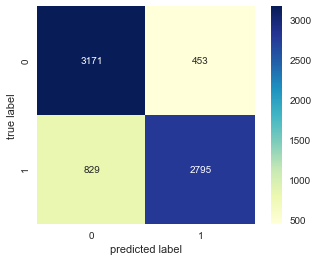

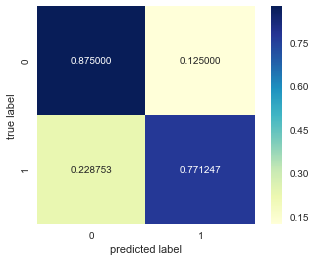

In [102]:
print("saving confusion matrix for decision tree...")
plot_confusion_matrix(y_test_upsampled, y_pred, "decision_tree_upsampled_conf_matrix")

In [110]:
print(accuracy_score(y_test_upsampled, y_pred))
print(recall_score(y_test_upsampled, y_pred))
print(precision_score(y_test_upsampled, y_pred))

0.8231236203090507
0.7712472406181016
0.8605295566502463


In [221]:
print("save decision tree with few depth layers for visualization: ")
dec_tree = tree.DecisionTreeClassifier(max_depth = 4, random_state=42)
dec_tree = dec_tree.fit(X_train_upsampled, y_train_upsampled)
y_pred = dec_tree.predict(X_test_upsampled)
print(accuracy_score(y_test_upsampled, y_pred))

save decision tree with few depth layers for visualization: 
0.6733204845814978


In [222]:
plot_dec_tree(dec_tree, feature_names=X_train_downsampled.drop(columns=["nb_prod_act","num_years_antig","has_gas"]).columns, filename="decision_tree_upsampled")

### Random forest on downsampled data: 

In [118]:
def get_best_random_forest(X_train,y_train,X_test, y_test):
    best_acc = 0
    best_depth = 0
    for i in range(3,40):
        rf = RandomForestClassifier(max_depth=i, random_state=42)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        acc_score = accuracy_score(y_test, y_pred)
        if acc_score > best_acc: 
            best_acc = acc_score
            best_depth = i
    rf = RandomForestClassifier(max_depth=best_depth, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    print("accuracy = " + str(accuracy_score(y_test, y_pred)))
    return rf, y_pred

In [119]:
rf_classifier, y_pred = get_best_random_forest(X_train=X_train_downsampled, y_train=y_train_downsampled,
                                       X_test=X_test_downsampled, y_test=y_test_downsampled)

accuracy = 0.6328320802005013


saving confusion matrix ...
confusion matrix normalized: 


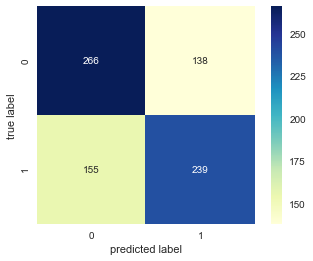

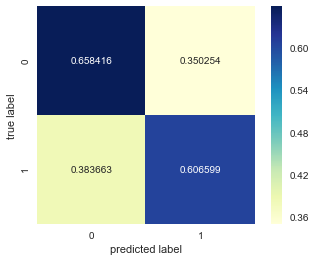

In [120]:
print("saving confusion matrix ...")
plot_confusion_matrix(y_test_downsampled, y_pred, "random_forest_conf_mat.pdf")

In [121]:
rf_classifier, y_pred = get_best_random_forest(X_train=X_train_no_colinear_cols, y_train=y_train_downsampled,
                                       X_test=X_test_no_colinear_cols, y_test=y_test_downsampled)

accuracy = 0.6466165413533834


In [122]:
print(accuracy_score(y_test_downsampled, y_pred))
print(recall_score(y_test_downsampled, y_pred))
print(precision_score(y_test_downsampled, y_pred))

0.6466165413533834
0.6269035532994924
0.6465968586387435


In [ ]:
print("saving confusion matrix ...")
plot_confusion_matrix(y_test_downsampled, y_pred, "random_forest_conf_mat.pdf")

### Random forest on upsampled data: 

In [148]:
rf_classifier, y_pred = get_best_random_forest(X_train=X_train_upsampled, y_train=y_train_upsampled,
                                       X_test=X_test_upsampled, y_test=y_test_upsampled)

accuracy = 0.8357654185022027


In [149]:
print(accuracy_score(y_test_upsampled, y_pred))
print(recall_score(y_test_upsampled, y_pred))
print(precision_score(y_test_upsampled, y_pred))

0.8357654185022027
0.7243942731277533
0.9319872476089267


saving confusion matrix ...
confusion matrix normalized: 


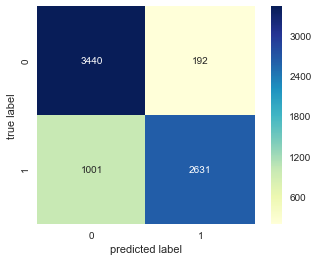

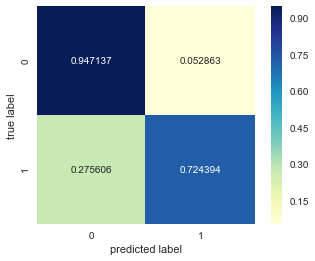

In [150]:
print("saving confusion matrix ...")
plot_confusion_matrix(y_test_upsampled, y_pred, "random_forest_upsampled_conf_mat")

## Scale the data

In [151]:
from sklearn.preprocessing import StandardScaler

In [152]:
# have to scale the data s.t. the relative variance can be distinguished for PCA
X_train_normalized = StandardScaler().fit_transform(X_train_downsampled)
X_test_normalized  = StandardScaler().fit_transform(X_test_downsampled)

In [153]:
# have to scale the data s.t. the relative variance can be distinguished for PCA
X_train_normalized_no_col = StandardScaler().fit_transform(X_train_no_colinear_cols)
X_test_normalized_no_col  = StandardScaler().fit_transform(X_test_no_colinear_cols)

In [154]:
# have to scale the data s.t. the relative variance can be distinguished for PCA
X_train_upsampled_normalized = StandardScaler().fit_transform(X_train_upsampled)
X_test_upsampled_normalized  = StandardScaler().fit_transform(X_test_upsampled)

## Dimensionality reduction 

### PCA  and k-NN

In [155]:
from sklearn.decomposition import PCA

In [156]:
def pca_and_plot(X_train, y_train):
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(X_train)
    y_df = pd.DataFrame(data = y_train, columns=["churn"])
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
    finalDf = pd.concat([principalDf, y_df], axis=1)
    # 2d plot: 
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(111)
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_title('2 component PCA')
    targets = [0,1]
    colors = ['gray', '#127161']
    markers = ['^','o']
    for target, color in zip(targets,colors):
        indicesToKeep = finalDf['churn'] == target
        ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
                   , finalDf.loc[indicesToKeep, 'principal component 2']
                   , c = color
                   , marker=markers[target]
                   , s = 10)
    ax.legend(targets)
    ax.grid()

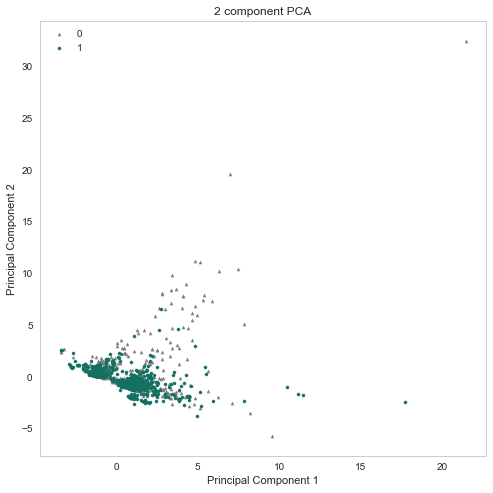

In [164]:
pca_and_plot(X_train=X_train_normalized_no_col, y_train=y_train_downsampled)

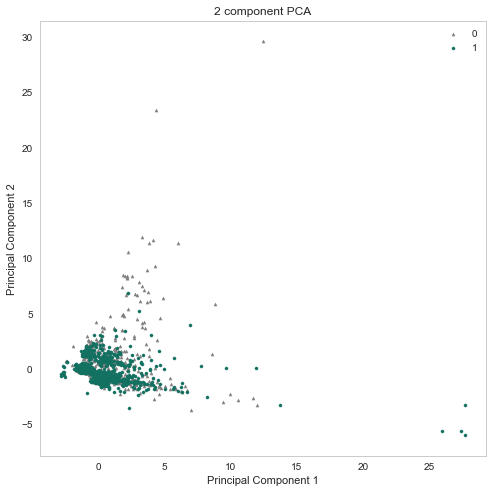

In [165]:
pca_and_plot(X_train=X_train_normalized, y_train=y_train_downsampled)

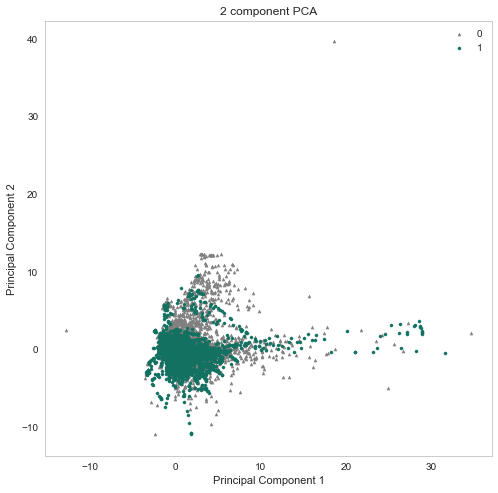

In [166]:
pca_and_plot(X_train=X_train_upsampled_normalized, y_train=y_train_upsampled)

### Nearest neighbour classification on PCA data  

In [167]:
from sklearn.neighbors import KNeighborsClassifier

In [172]:
def get_best_pca_components(X_train, X_test, y_train, y_test): 
    best_acc = 0
    best_n_components = 0
    best_n_neighbours = 0
    for i in range(1,X_train.shape[1]):
        pca = PCA(n_components=i)
        principalComponents = pca.fit_transform(X_train)
        principalComponentsTest = pca.fit_transform(X_test)
        for j in range(1,10):
            knn = KNeighborsClassifier(n_neighbors=j)
            knn.fit(principalComponents, y_train) 
            y_pred = knn.predict(principalComponentsTest)
            acc = accuracy_score(y_test, y_pred)
            if acc > best_acc:
                best_acc = acc
                best_n_components = i
                best_n_neighbours = j
    pca = PCA(n_components=best_n_components)
    principalComponents = pca.fit_transform(X_train)
    principalComponentsTest = pca.fit_transform(X_test)
    knn = KNeighborsClassifier(n_neighbors=best_n_neighbours)
    knn.fit(principalComponents, y_train) 
    y_pred = knn.predict(principalComponentsTest)
    print(accuracy_score(y_test, y_pred))
    return knn, pca, principalComponents, principalComponentsTest, y_pred

In [173]:
knn, pca, principalComponents, principalComponentsTest, y_pred = get_best_pca_components(X_train=X_train_normalized, y_train=y_train_downsampled,
                                       X_test=X_test_normalized, y_test=y_test_downsampled)

0.5388471177944862


In [174]:
print(accuracy_score(y_test_downsampled, y_pred))
print(recall_score(y_test_downsampled, y_pred))
print(precision_score(y_test_downsampled, y_pred))

0.5388471177944862
0.5964467005076142
0.5292792792792793


In [175]:
knn, pca, principalComponents, principalComponentsTest, y_pred = get_best_pca_components(X_train=X_train_upsampled_normalized, y_train=y_train_upsampled,
                                       X_test=X_test_upsampled_normalized, y_test=y_test_upsampled)

0.545704845814978


In [178]:
print(accuracy_score(y_test_upsampled, y_pred))
print(recall_score(y_test_upsampled, y_pred))
print(precision_score(y_test_upsampled, y_pred))

0.545704845814978
0.8199339207048458
0.5295163584637269


confusion matrix normalized: 


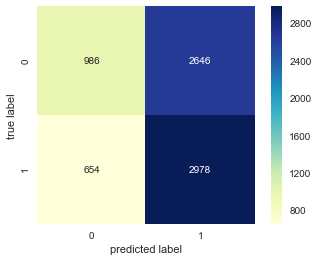

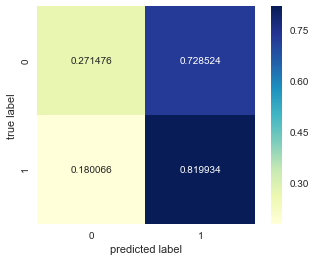

In [177]:
plot_confusion_matrix(y_test_upsampled, y_pred, "pca_knn_upsampled")

### LDA 

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [ ]:
lda = LinearDiscriminantAnalysis()
lda_result = lda.fit(X_train_normalized, y_train_downsampled).transform(X_train_normalized)
y_pred = lda.predict(X_test_normalized)
accuracy_score(y_test_downsampled, y_pred)

In [ ]:
lda = LinearDiscriminantAnalysis()
lda_result = lda.fit(X_train_normalized_no_col, y_train_downsampled).transform(X_train_normalized_no_col)
y_pred = lda.predict(X_test_normalized_no_col)
accuracy_score(y_test_downsampled, y_pred)

### t-SNE and isomap 

In [ ]:
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap

In [ ]:
tsne = TSNE()

In [ ]:
tsne_result = tsne.fit_transform(X_train_normalized,y_train_downsampled)
# tsne_result.dump("tsne_result.pickle")
# tsne = np.load("tsne_result.pickle")

In [ ]:
tsne_result

In [ ]:
plt.figure()
colors = ['navy', 'turquoise']
for color, i, target_name in zip(colors, [0,1], [0,1]):
    plt.scatter(tsne_result[y_train_downsampled == i,0], tsne_result[y_train_downsampled == i,1], alpha=.8, color=color,label=target_name)
plt.legend(labels=["0","1"])

In [ ]:
isomap = Isomap(10,2)

In [ ]:
isomap_result = isomap.fit_transform(X_train_normalized)
# isomap_result.dump("isomap_result.pickle")
# isomap_result = np.load("isomap_result.pickle")

In [ ]:
plt.figure()
colors = ['navy', 'turquoise']
for color, i, target_name in zip(colors, [0,1], [0,1]):
    plt.scatter(isomap_result[y_train_downsampled == i,0], isomap_result[y_train_downsampled == i,1], alpha=.8, color=color,label=target_name)
plt.legend(labels=["0","1"])

### SVMs 

In [179]:
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train_normalized, y_train_downsampled)  
y_pred = clf.predict(X_test_normalized)
print(accuracy_score(y_test_downsampled, y_pred))
print(recall_score(y_test_downsampled, y_pred))
print(precision_score(y_test_downsampled, y_pred))

0.6015037593984962
0.5329949238578681
0.6104651162790697


In [180]:
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train_upsampled_normalized, y_train_upsampled)  
y_pred = clf.predict(X_test_upsampled_normalized)
print(accuracy_score(y_test_upsampled, y_pred))
print(recall_score(y_test_upsampled, y_pred))
print(precision_score(y_test_upsampled, y_pred))

0.6891519823788547
0.5443281938325991
0.7662790697674419


In [ ]:
plot_confusion_matrix(y_test_upsampled, y_pred, "svm_conf_mat")

### Logistic regression 

In [181]:
from sklearn.linear_model import LogisticRegression

In [182]:
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train_normalized_no_col,y_train_downsampled)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [186]:
y_pred = logisticRegr.predict(X_test_normalized_no_col)
print(accuracy_score(y_test_downsampled, y_pred))
print(recall_score(y_test_downsampled, y_pred))
print(precision_score(y_test_downsampled, y_pred))

0.556390977443609
0.649746192893401
0.5423728813559322


In [187]:
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train_upsampled_normalized,y_train_upsampled)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [189]:
y_pred = logisticRegr.predict(X_test_upsampled_normalized)
print(accuracy_score(y_test_upsampled, y_pred))
print(recall_score(y_test_upsampled, y_pred))
print(precision_score(y_test_upsampled, y_pred))

0.5970539647577092
0.5663546255506607
0.6034027574068642


### Prediction:  

In [ ]:
rf_classifier.score(X_test_upsampled, y_test_upsampled)

In [ ]:
numeric_test_data = numeric_test_data.drop(columns=["nb_prod_act","num_years_antig","has_gas"])# drop discrete values

In [ ]:
pred = rf_classifier.predict(numeric_test_data).astype(np.int16)

In [ ]:
churn_prob = rf_classifier.predict_proba(numeric_test_data)[:,1]

In [ ]:
pred_df = pd.DataFrame(data = pred, columns=["Churn_prediction"],index=numeric_test_data.index)

In [ ]:
pred_df["Churn_probability"] = churn_prob

In [ ]:
prediction = pd.concat((test_data_output, pred_df), axis=1).dropna(axis=1)

In [ ]:
prediction.to_csv("results/ml_case_test_output_template.csv")

### Recommendation: 

In [206]:
prediction = pd.read_csv("results/ml_case_test_output_template.csv", index_col="id")

In [209]:
recommendation = pd.concat((numeric_test_data,prediction.drop(columns=["Unnamed: 0"])), axis=1)

In [211]:
recommendation

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,Churn_prediction,Churn_probability
id,,,,,,,,,,,,,,,,,,,,
ed18c9981ce183ef347246cdcc55f743,42132,0,3215,4001.08,3215,0.0,130.43,0.114603,0.098261,40.606701,0,296.90,9.63,9.63,1,488.25,4,20.000,0,0.245782
9c341e73685fcff6e3527ebd51da3fe5,3537,0,563,518.22,563,0.0,23.20,0.142174,0.000000,44.444710,0,80.66,0.12,0.12,1,29.18,5,15.000,0,0.125164
97dd64b33716aadc4e22c4ab85d1c7a4,6543,0,399,639.65,399,0.0,130.32,0.115182,0.098841,40.606701,0,37.91,15.53,15.53,1,74.59,5,17.321,0,0.298408
cf81de72ff7997ed10729751059cf7a3,186838,0,12091,2634.23,738,0.0,16.42,0.164058,0.086163,44.311378,0,93.12,27.00,27.00,1,210.18,5,11.951,0,0.285958
c7c8ee9daf2a864d159d45a2373ada72,19051,0,0,2801.47,0,0.0,0.00,0.141434,0.000000,44.311378,0,0.00,8.62,8.62,1,223.23,4,13.150,0,0.251525
e71dcb748e269fee09b9f42f4c52fcc4,11486,9707,321,212.70,0,24.0,14.60,0.182936,0.000000,47.800878,1,0.00,35.18,35.18,4,12.44,3,10.392,0,0.428498
09bf08782759c0f550bdfcdcbcc5204f,9390,0,0,1405.51,0,0.0,22.38,0.143805,0.000000,44.311378,0,0.00,32.88,32.88,1,124.37,6,13.150,1,0.656268
b4f626597ef9df75224af10e47842e54,41648,0,4103,2158.93,2403,0.0,131.76,0.114604,0.098262,40.606701,0,230.87,18.12,18.12,1,236.57,7,19.800,0,0.346709
0218b6cd2582012e85e3fa88512edd74,24675,0,1606,1542.80,1606,0.0,132.11,0.114025,0.097683,40.606701,0,148.88,15.80,15.80,1,181.96,5,17.250,0,0.366325


In [254]:
recommendation.sort_values(by="Churn_probability")

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,Churn_prediction,Churn_probability
id,,,,,,,,,,,,,,,,,,,,
f58cfe1d26fe8b0044b0e2a7100fb7c8,2882597,976731,382647,3332.97,6053,0.0,16.66,0.162033,0.084138,44.311378,1,659.35,23.40,23.40,2,315.07,6,10.392,0,0.000000
a9aa17899883f892e3256d29a64c939f,2882597,976731,382647,6399.22,6222,0.0,131.49,0.115744,0.098858,40.606701,1,576.69,18.48,18.48,2,624.72,6,18.500,0,0.000000
6a5352220ac93def8f526f02303d93d9,19371,0,3545,0.00,408,0.0,0.00,0.000600,0.000000,0.000000,0,0.00,48.07,48.07,1,82.05,6,21.000,0,0.000000
a30c9662a72d86bb0903443892b083d8,4939487,1860052,426460,5318.25,8192,0.0,145.83,0.113206,0.093991,40.728885,1,699.53,0.00,0.00,2,429.72,5,19.800,0,0.000000
e485478b522c2d5853830cf12e32d388,5322441,921247,760727,5993.24,14377,0.0,17.14,0.159815,0.081173,44.311378,1,1533.25,-0.88,-0.88,32,204.36,6,10.392,0,0.000000
0611cd948dde6bbafad56cd97c2e0e64,33957,0,0,0.00,0,0.0,0.00,0.000000,0.000000,0.000000,0,0.00,25.30,25.30,1,113.58,9,11.000,0,0.000000
3e30ccec6908e3e2796c86b6f48c05a2,5731448,0,771203,2730.51,5134,0.0,28.54,0.164057,0.086803,44.311378,0,545.98,13.10,13.10,1,214.30,5,10.390,0,0.000000
33f3386f425ffd95c43d398d3940da29,2768910,0,198800,2217.32,0,0.0,121.57,0.110565,0.093638,40.728885,0,0.00,0.00,0.00,1,0.00,6,15.001,0,0.000000
d63937a6d60fc26b2cf69de1dd50a8d0,4306656,888994,479030,2103.30,1889,0.0,16.01,0.165022,0.086380,44.311378,1,231.36,4.86,4.86,2,155.25,5,10.392,0,0.000000


In [231]:
n_churns = recommendation[recommendation["Churn_prediction"] == 1].shape[0]

In [232]:
n_churns*0.725

260.275

In [248]:
recommendation.sort_values(by="Churn_probability")[-260:]["net_margin"].sum()*0.2 #72.5% will get 20 %discount

12067.594000000001

In [249]:
recommendation.sort_values(by="Churn_probability")[-458:-359]["net_margin"].sum() #27.6% were wrongly classified to stay and leave

27199.52

In [250]:
recommendation.sort_values(by="Churn_probability")[-359:-339]["net_margin"].sum() # 5% actually stay

4623.049999999999

In [252]:
recommendation.sort_values(by="Churn_probability")[-359:]["net_margin"].sum() # all churning customers

81088.0